In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GlobalAveragePooling1D, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt
import os
from dtaidistance import dtw
from IPython.display import Image

In [2]:
dataset_dir = '/home'
big_tank_df = pd.read_csv(f'{dataset_dir}/final_dataset.csv')

In [3]:
def load_test_datasets():
    test_datasets = []
    for i in range(1, 4):
        test_datasets.append(pd.read_csv(f'{dataset_dir}/test_df_{i}.csv'))
    return test_datasets

In [4]:
test_df_1, test_df_2, test_df_3 = load_test_datasets()

In [5]:
test_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp_ft         20000 non-null  float64
 1   torque_x             20000 non-null  float64
 2   torque_y             20000 non-null  float64
 3   torque_z             20000 non-null  float64
 4   timestamp_cmd        20000 non-null  float64
 5   frequency            20000 non-null  float64
 6   position             20000 non-null  int64  
 7   position_cmd         20000 non-null  float64
 8   converted_pos_cmd    20000 non-null  float64
 9   converted_pos        20000 non-null  float64
 10  torque_x_calibrated  20000 non-null  float64
 11  torque_y_calibrated  20000 non-null  float64
 12  force_y              20000 non-null  float64
 13  force_x              20000 non-null  float64
 14  target_angle         20000 non-null  float64
 15  angular_vel          20000 non-null 

In [6]:
big_tank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990000 entries, 0 to 1989999
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   timestamp_ft         float64
 1   torque_x             float64
 2   torque_y             float64
 3   torque_z             float64
 4   timestamp_cmd        float64
 5   frequency            float64
 6   position             int64  
 7   position_cmd         float64
 8   converted_pos_cmd    float64
 9   converted_pos        float64
 10  torque_x_calibrated  float64
 11  torque_y_calibrated  float64
 12  force_y              float64
 13  force_x              float64
 14  target_angle         float64
 15  angular_vel          float64
dtypes: float64(15), int64(1)
memory usage: 242.9 MB


# General architecture of surrogate model
PosNet is 1D Convolutional Neural Network.
ForceNet is based on 1 layer LSTM

![title](model_architecture.png)

# Data analysis

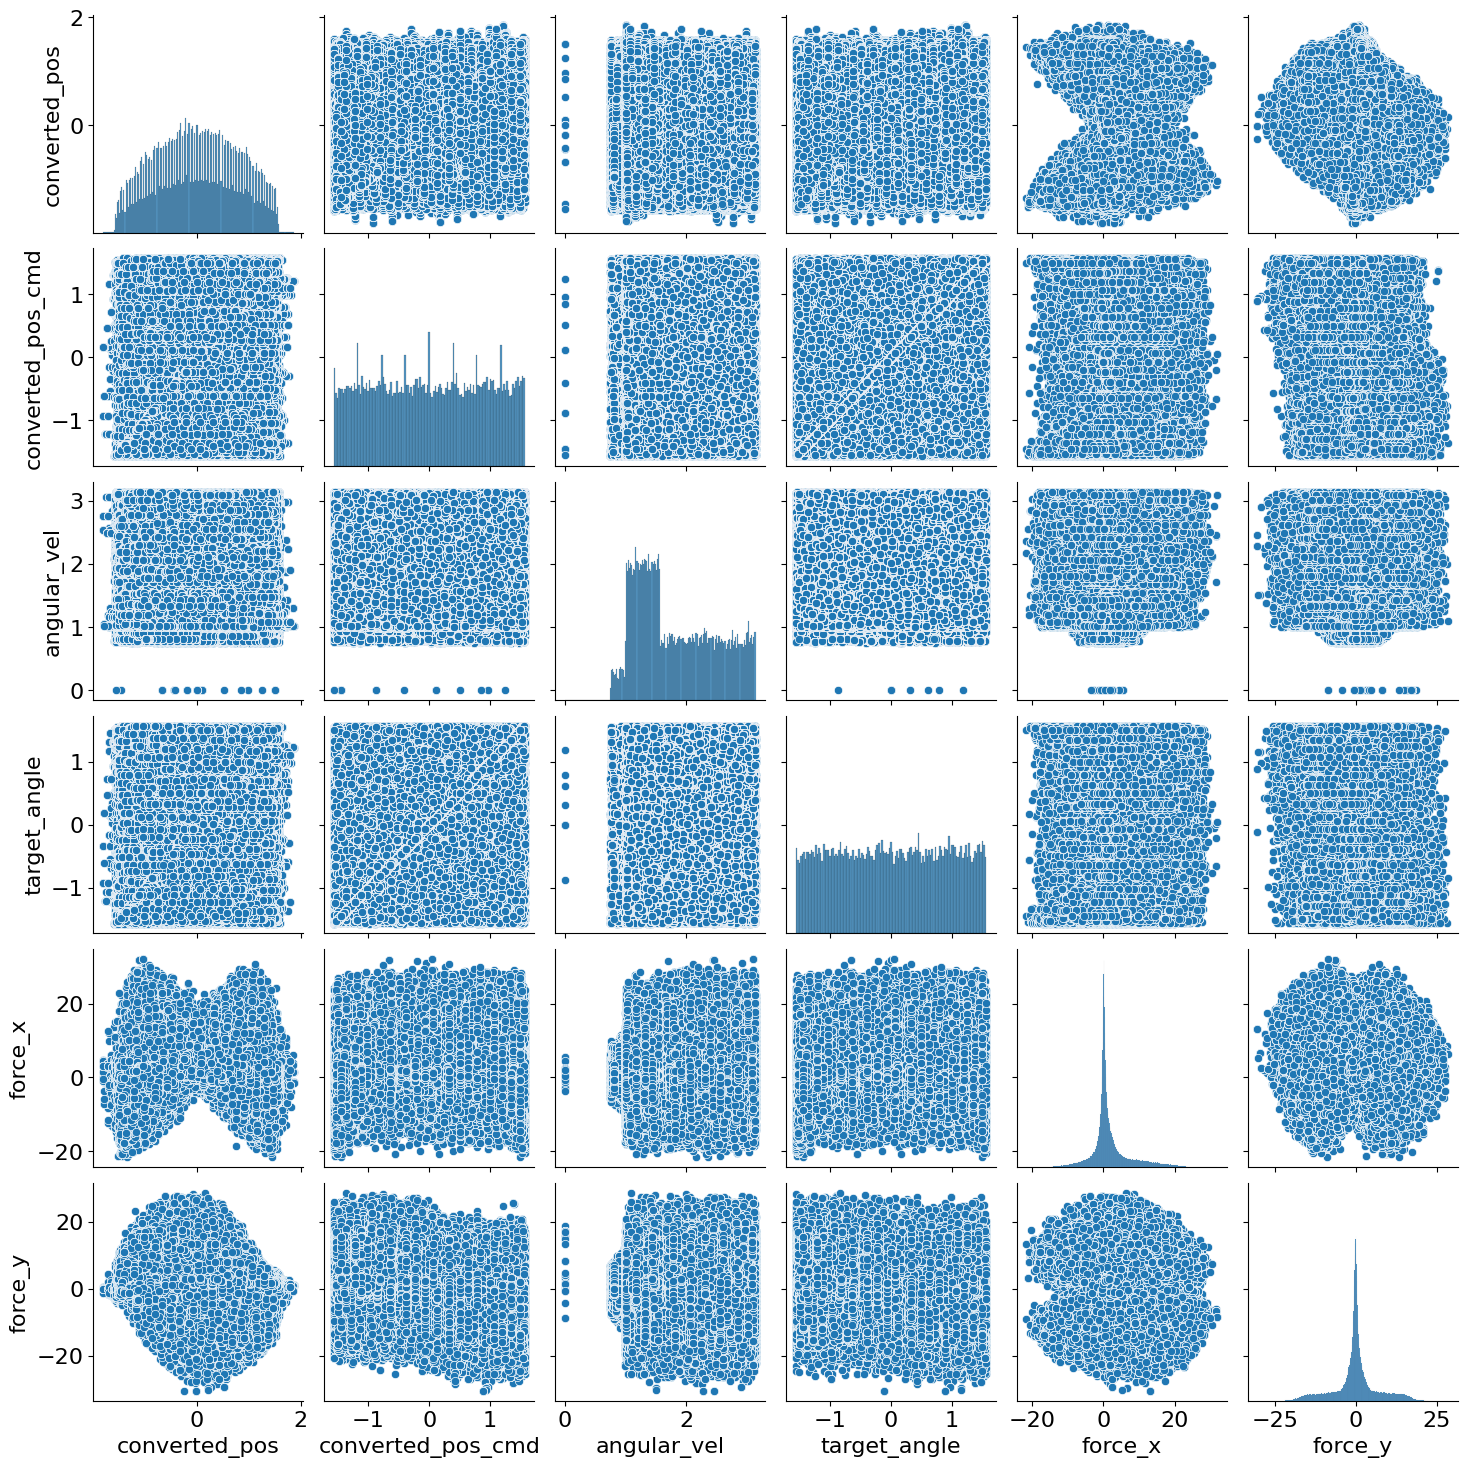

In [25]:
sns.pairplot(big_tank_df[['converted_pos', 'converted_pos_cmd', 'angular_vel', 'target_angle', 'force_x', 'force_y']])

/tmp/ipykernel_1401023/1331217041.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


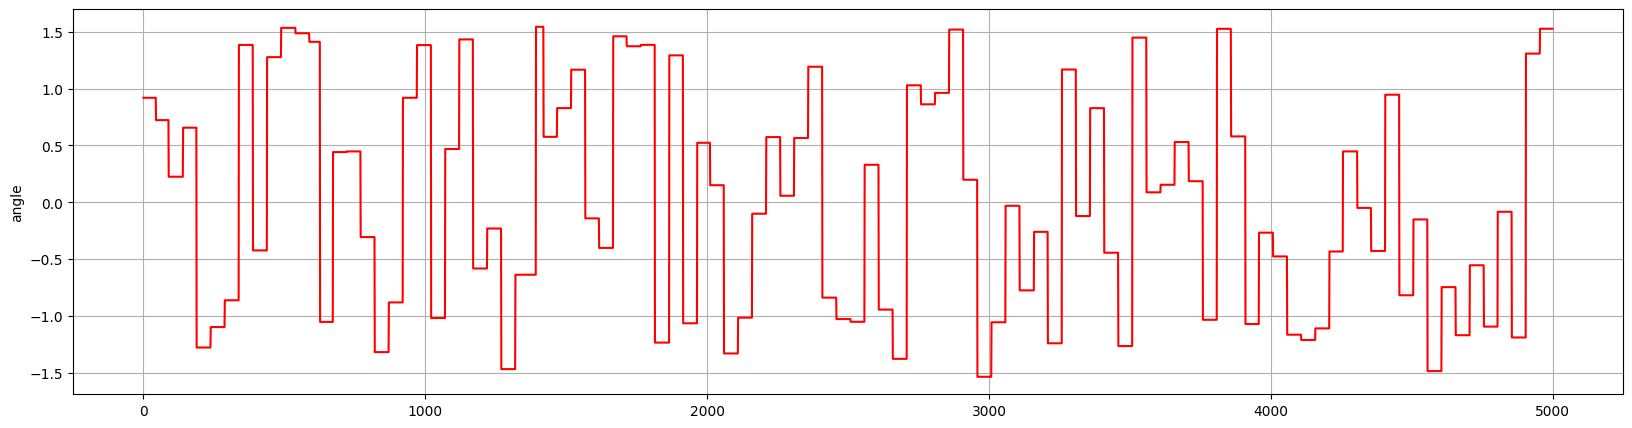

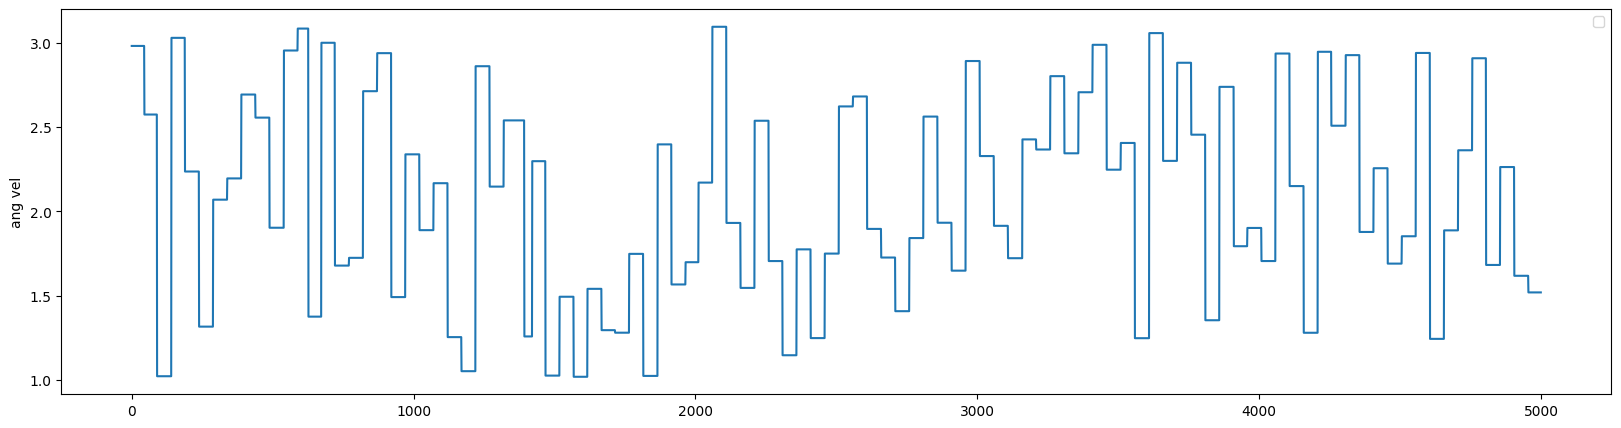

In [20]:
dataset = big_tank_df.copy()
plt.rcParams["figure.figsize"] = [20, 5]
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
targ_angle, ang_vel = dataset['target_angle'], dataset['angular_vel']
timestamp = dataset['timestamp_cmd']
ax.plot(targ_angle[0:5000], color='red')
ax2.plot(ang_vel[0:5000])

ax.set_ylabel("angle")
ax2.set_ylabel("ang vel")
plt.legend()
ax.grid()
plt.show()

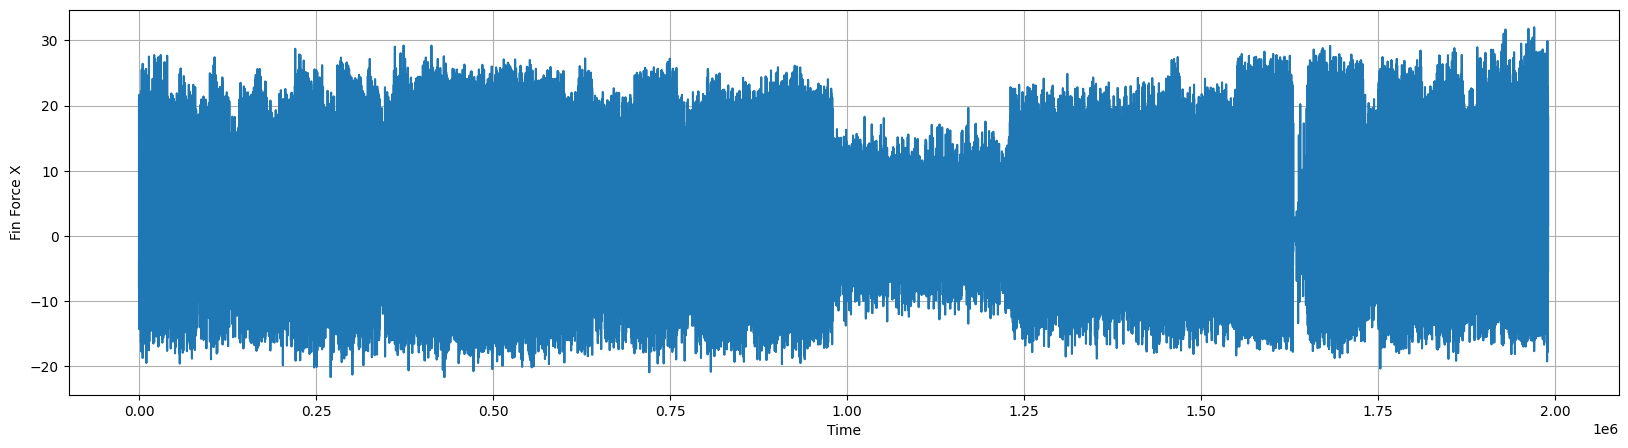

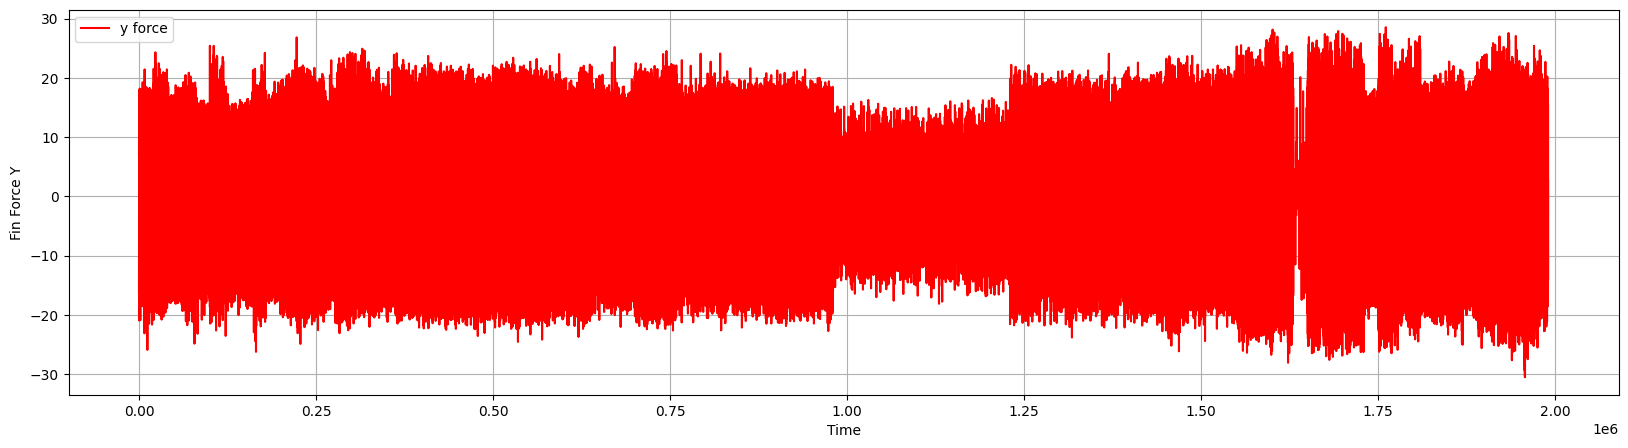

In [21]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

ax.plot(dataset['force_x'], label="x force")
ax2.plot(dataset['force_y'], label="y force", color="red")
#ax.plot(df['timestamp_ft'], df['force_y'], label="y force", color="brown")

ax.set_xlabel("Time")
ax.set_ylabel("Fin Force X")
ax.grid()
ax2.set_xlabel("Time")
ax2.set_ylabel("Fin Force Y")
ax2.grid()

plt.legend(loc='best')
plt.show()

# Filtering

Using band-pass filter to remove high frequency noise and low frequency drift from the raw force signal

In [74]:
def butter_lowpass(lowcut, fs, order=4):
    '''Lowpass filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_highpass(highcut, fs, order=4):
    '''High pass filter
    '''
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a


def butter_lowpass_filter(x, lowcut, duration, order=4):
    '''Conductinig lowpass fillter
    '''
    fs = len(x) / duration
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.filtfilt(b, a, x)
    return y

def butter_highpass_filter(x, highcut, duration, order=4):
    '''conductiong highpass filter
    '''
    fs = len(x) / duration
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, x)
    return y

## Force filtering

16115.063770025969
16115.063770025969


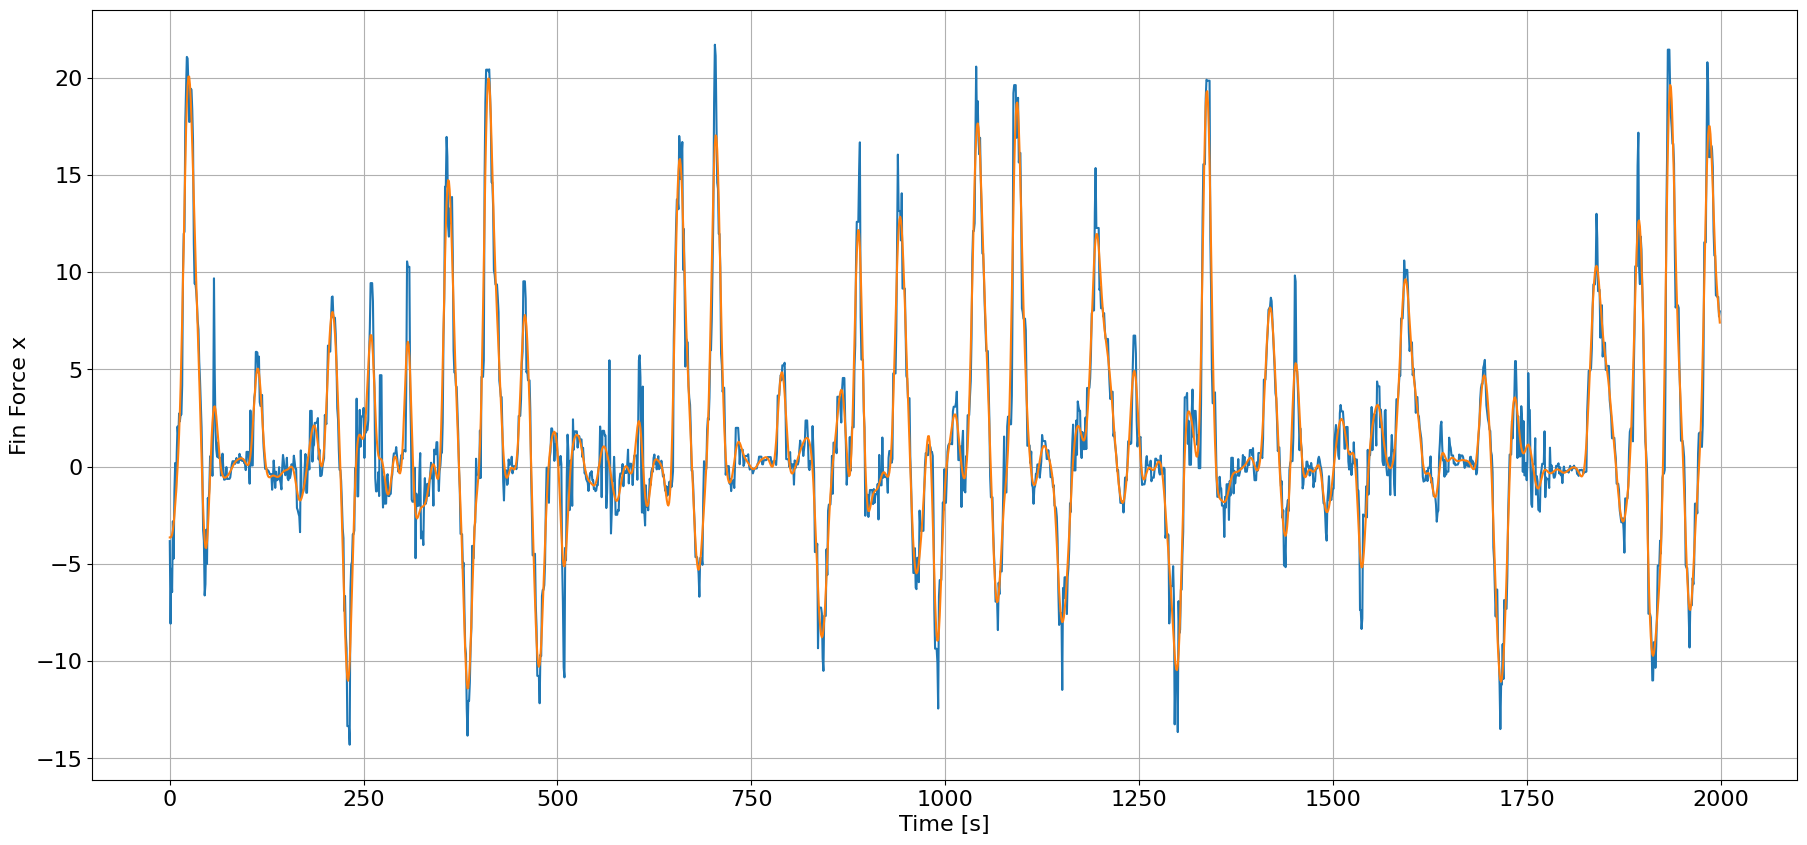

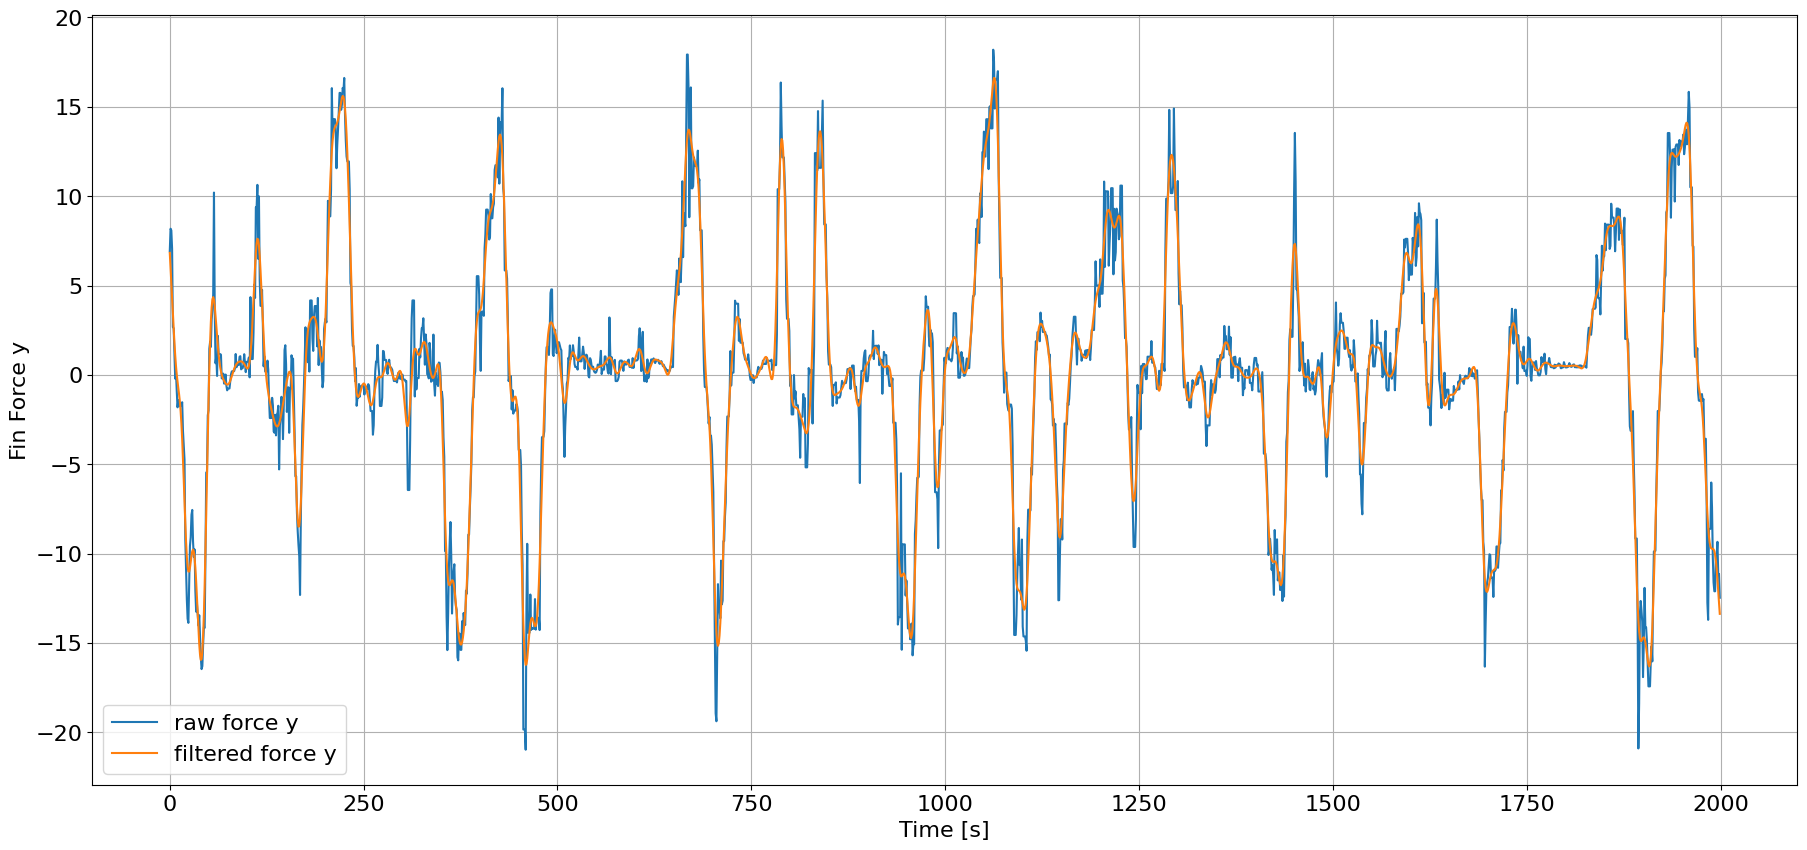

In [ ]:
def force_filtering(dataset, force, is_training_data=True):
  force = dataset[force]
  if is_training_data:
    timestamp = (dataset["timestamp_ft"] * -1/10).values
  else:
    timestamp = (dataset["timestamp_ft"]).values
  #print(timestamp)
  duration = timestamp[-1] - timestamp[0]
  print(duration)

  lowcut = 20.0 
  highcut = 8.0
  force_filtered = butter_lowpass_filter(force, lowcut, duration, order=4)
  force_filtered = butter_highpass_filter(force_filtered, highcut, duration, order=4)
  return force_filtered



force_x = big_tank_df["force_x"]
force_y = big_tank_df["force_y"]
timestamp = big_tank_df["timestamp_ft"].values

force_x_filtered = force_filtering(big_tank_df, "force_x", is_training_data=True)
force_y_filtered = force_filtering(big_tank_df, "force_y", is_training_data=True)

plt.rcParams["figure.figsize"] = [22, 10]
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
ax.plot(force_x[0:2000], label='raw force x')
ax.plot(force_x_filtered[0:2000], label='filtered force x')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fin Force x")

ax2.plot(force_y[0:2000], label='raw force y')
ax2.plot(force_y_filtered[0:2000], label='filtered force y')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Fin Force y")

ax.grid()
ax2.grid()
plt.legend(loc='best')
plt.show()

## Position filtering

Using filter to smoothen position data

16115.063770025969


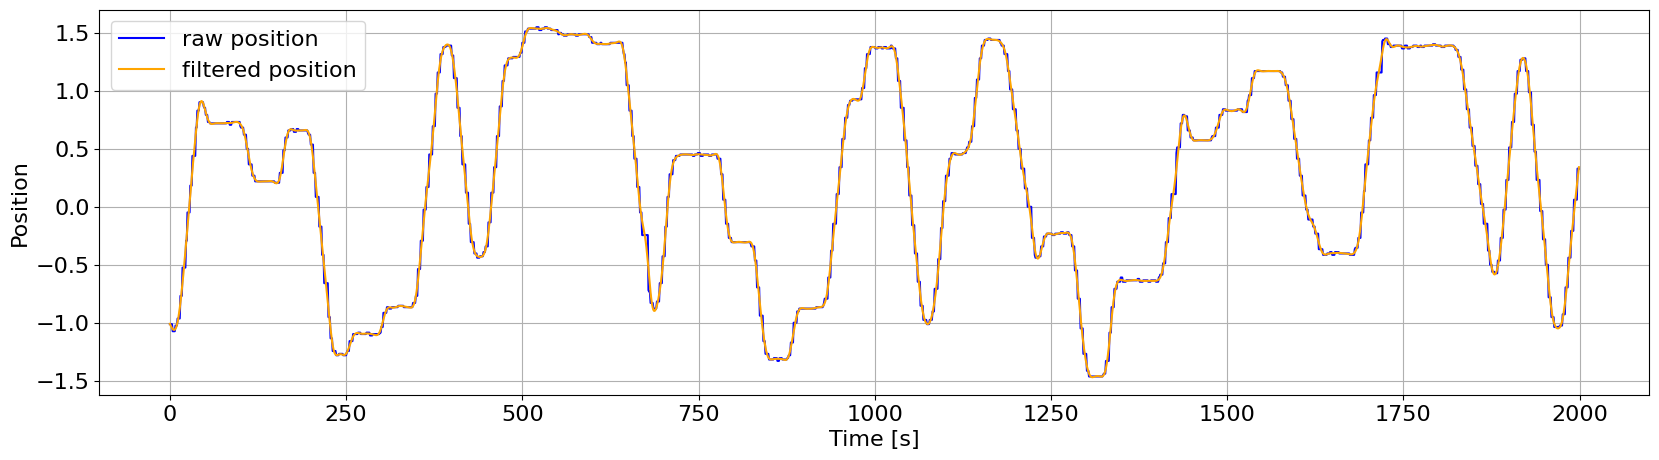

In [ ]:
def position_filtering(dataset, is_training_data=True):
  position = dataset['converted_pos']
  if is_training_data:
    timestamp = (dataset["timestamp_ft"] * -1/10).values
  else:
    timestamp = (dataset["timestamp_ft"]).values
  #print(timestamp)
  duration = timestamp[-1] - timestamp[0]
  print(duration)

  lowcut = 20.0 
  highcut = 8.0
  position_filtered = butter_lowpass_filter(position, lowcut, duration, order=4)
  position_filtered = butter_highpass_filter(position_filtered, highcut, duration, order=4)
  return position_filtered

position = big_tank_df["converted_pos"]
position_filtered = position_filtering(big_tank_df, is_training_data=True)

plt.rcParams["figure.figsize"] = [20, 5]
fig, ax = plt.subplots()
ax.plot(position[0:2000], label='raw position', color="blue")
ax.plot(position_filtered[0:2000], label='filtered position', color="orange")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position")
ax.grid()
plt.legend(loc='best')
plt.show()

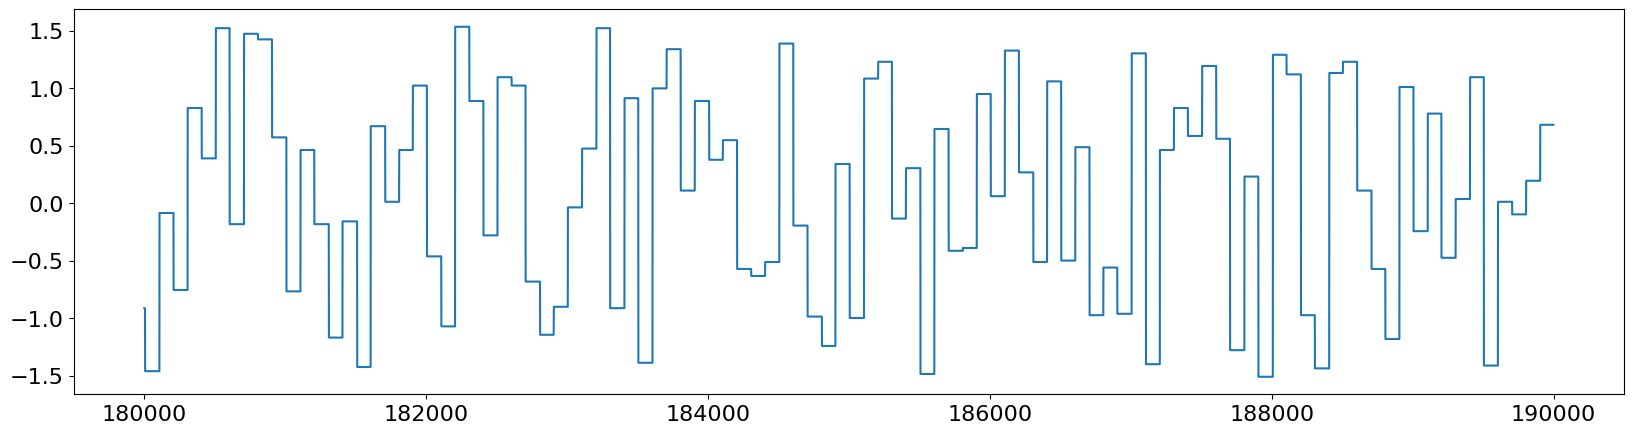

In [26]:
plt.plot(big_tank_df["converted_pos_cmd"][180000:190000])

# Data preprocessing functions

In [26]:
scaler_fx = MinMaxScaler(feature_range=(0, 1))
scaler_fy = MinMaxScaler(feature_range=(0, 1))
scaler_pos_cmd = MinMaxScaler(feature_range=(0, 1))
scaler_pos = MinMaxScaler(feature_range=(0, 1))
scaler_ang_vel = MinMaxScaler(feature_range=(0, 1))
scaler_target_angle = MinMaxScaler(feature_range=(0, 1))

In [27]:
def scale_dataset(df, is_training=True):
    scaled_features = []
    columns = df.columns

    # Helper function to apply scaler
    def apply_scaler(scaler, data, column_name):
        if is_training:
            scaled_data = scaler.fit_transform(data[[column_name]])
        else:
            scaled_data = scaler.transform(data[[column_name]])
        return scaled_data

    # Scaling logic per column
    if 'force_x_filtered' in columns:
        force_x_scaled = apply_scaler(scaler_fx, df, 'force_x_filtered')
        scaled_features.append(force_x_scaled)

    if 'force_y_filtered' in columns:
        force_y_scaled = apply_scaler(scaler_fy, df, 'force_y_filtered')
        scaled_features.append(force_y_scaled)

    if 'converted_pos' in columns:
        position_scaled = apply_scaler(scaler_pos, df, 'converted_pos')
        scaled_features.append(position_scaled)

    if 'converted_pos_cmd' in columns:
        position_cmd_scaled = apply_scaler(scaler_pos_cmd, df, 'converted_pos_cmd')
        scaled_features.append(position_cmd_scaled)

    if 'angular_vel' in columns:
        angular_vel_scaled = apply_scaler(scaler_ang_vel, df, 'angular_vel')
        scaled_features.append(angular_vel_scaled)

    if 'target_angle' in columns:
        target_angle_scaled = apply_scaler(scaler_target_angle, df, 'target_angle')
        scaled_features.append(target_angle_scaled)

    # Concatenate all scaled features into a final dataset
    scaled_dataset = np.hstack(scaled_features) if scaled_features else np.array([]).reshape(len(df), 0)

    return scaled_dataset

Transforming the dataset to supervised learning format by generating sliding windows of input-output pairs

In [28]:
def preprocess_data(df, num_outputs, is_training=True):

  window = 100
  dataset = scale_dataset(df, is_training)

  def make_dataset(dataset, look_back=1):
      dataX, dataY = [], []
      for i in range(len(dataset) - look_back - 1):
          xset = []
          yset = []

          for j in range(num_outputs, dataset.shape[1]):
              input = dataset[i:(i + look_back), j]
              xset.append(input)

          for target in range(0, num_outputs):
              yset.append(dataset[i + look_back, target])

          dataX.append(xset)
          dataY.append(yset)
      return np.array(dataX), np.array(dataY)

  look_back = window
  trainX, trainY = make_dataset(dataset, look_back)

  print(trainX.shape)
  # reshape input to be [samples, features, timesteps]
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))

  print(trainX[:10, :])

  return trainX, trainY

# Data postprocessing functions

Helper functions to compute models inference, calculate metrics score

In [29]:
def compute_dtw_similarity(testY, testPredict):
  similarity_score_list = []
  for i in range(len(testY)):
    test_y = testY[i]
    test_predict = testPredict[i]

    # Ensure sequences are 1D before passing to dtw
    distance, paths = dtw.warping_paths(test_y, test_predict, use_c=False)
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)

    similarity_score_list.append(similarity_score)

  return np.mean(similarity_score_list)

In [30]:
def inverse_scale_forces(df, testPredict, testY, scaler_fx, scaler_fy):
  pad_col = np.zeros(df.shape[1]-1)
  def pad_array(val):
      return np.array([np.insert(pad_col, 0, x) for x in val])

  # Inverse transforming the predictions and actual values
  x_testPredict = scaler_fx.inverse_transform(pad_array(testPredict[:,0]))
  x_testY_ = scaler_fx.inverse_transform(pad_array(testY[:,0]))

  y_testPredict = scaler_fy.inverse_transform(pad_array(testPredict[:,1]))
  y_testY_ = scaler_fy.inverse_transform(pad_array(testY[:,1]))

  return x_testPredict, x_testY_, y_testPredict, y_testY_

In [31]:
def predict_and_plot_forces(model, testX, testY, scaler_fx, scaler_fy, df):

  testPredict = model.predict(testX)
  x_testPredict, x_testY_, y_testPredict, y_testY_ = inverse_scale_forces(df, testPredict, testY,  scaler_fx, scaler_fy)

  df_test = pd.DataFrame()
  df_test["x force"] = x_testY_[:,0]
  df_test["Predict"] = x_testPredict[:,0]

  df_test2 = pd.DataFrame()
  df_test2["y force"] = y_testY_[:,0]
  df_test2["Predict"] = y_testPredict[:,0]

  print('RMSE:')
  print(np.sqrt(mean_squared_error(x_testY_, x_testPredict)))
  print('MAE:')
  print(mean_absolute_error(x_testY_, x_testPredict))
  print('MAPE:')
  print(mean_absolute_percentage_error(x_testY_, x_testPredict))
  similarity_score = compute_dtw_similarity(x_testY_, x_testPredict)
  print('DTW Similarity Score:')
  print(similarity_score)

  df_test[0:1000].plot(kind='line')
  df_test2[0:1000].plot(kind='line')

In [32]:
def predict_and_plot_position(model, testX, testY, scaler_pos):

  testPredict = model.predict(testX)
  testPredict = testPredict.reshape(-1, 1)
  testY = testY.reshape(-1, 1)

  # Inverse transform predictions and actual values
  pos_testPredict =  scaler_pos.inverse_transform(testPredict)
  pos_testY =  scaler_pos.inverse_transform(testY)
  df_test = pd.DataFrame()
  df_test["position"] = pos_testY[:,0]
  df_test["Predict"] = pos_testPredict[:,0]

  print('RMSE:')
  print(np.sqrt(mean_squared_error(pos_testY, pos_testPredict)))
  print('MAE:')
  print(mean_absolute_error(pos_testY, pos_testPredict))
  print('MAPE:')
  print(mean_absolute_percentage_error(pos_testY, pos_testPredict))
  similarity_score = compute_dtw_similarity(pos_testY, pos_testPredict)
  print('DTW Similarity Score:')
  print(similarity_score)

  df_test[1000:3000].plot(kind='line')

In [33]:
def plot_loss(history):

  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='valid Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show()

In [35]:
def calculate_inference(df, model, testX, testY, scalers, predict_forces: bool):
  start_time = time.time()
  if predict_forces:
    scaler_fx, scaler_fy = scalers[0], scalers[1]
    predictions = predict_and_plot_forces(model, testX, testY, scaler_fx, scaler_fy, df)
  else:
    scaler_pos = scalers
    predictions = predict_and_plot_position(model, testX, testY, scaler_pos)

  end_time = time.time()
  prediction_time = end_time - start_time
  print(f"Inference time: {prediction_time}")


In [36]:
def test_posnet_model(model):
    df_test_1 = make_dataset_posnet(test_df_1, is_training_data=False)
    df_test_2 = make_dataset_posnet(test_df_2, is_training_data=False)
    df_test_3 = make_dataset_posnet(test_df_3, is_training_data=False)

    testX_1, testY_1 = preprocess_data(df_test_1, 1, is_training=False)
    testX_2, testY_2 = preprocess_data(df_test_2, 1, is_training=False)
    testX_3, testY_3 = preprocess_data(df_test_3, 1, is_training=False)

    calculate_inference(test_df_1, model, testX_1, testY_1, scaler_pos, predict_forces=False)
    calculate_inference(test_df_2, model, testX_2, testY_2, scaler_pos, predict_forces=False)
    calculate_inference(test_df_3, model, testX_3, testY_3, scaler_pos, predict_forces=False)

    return testX_1, testX_2

In [52]:
def test_forcenet_model(model):
    df_test_1 = make_dataset_forcenet(test_df_1, is_training_data=False)
    df_test_2 = make_dataset_forcenet(test_df_2, is_training_data=False)
    df_test_3 = make_dataset_forcenet(test_df_3, is_training_data=False)

    testX_1, testY_1 = preprocess_data(df_test_1, 2, is_training=False)
    testX_2, testY_2 = preprocess_data(df_test_2, 2, is_training=False)
    testX_3, testY_3 = preprocess_data(df_test_3, 2, is_training=False)
    scalers = [scaler_fx, scaler_fy]

    calculate_inference(test_df_1, model, testX_1, testY_1, scalers, predict_forces=True)
    calculate_inference(test_df_2, model, testX_2, testY_2, scalers, predict_forces=True)
    calculate_inference(test_df_3, model, testX_3, testY_3, scalers, predict_forces=True)

# Estimate position

## Make dataset

In [37]:
def make_dataset_posnet(df, is_training_data=True):
    df_copy = df.copy()
    df_pos_net = pd.DataFrame()

    df_pos_net['converted_pos'] = position_filtering(df_copy, is_training_data) 
    df_pos_net['converted_pos_cmd'] = df_copy['converted_pos_cmd']
    df_pos_net['angular_vel'] = df_copy['angular_vel']
    return df_pos_net

16115.063770025969
(1990000, 3)


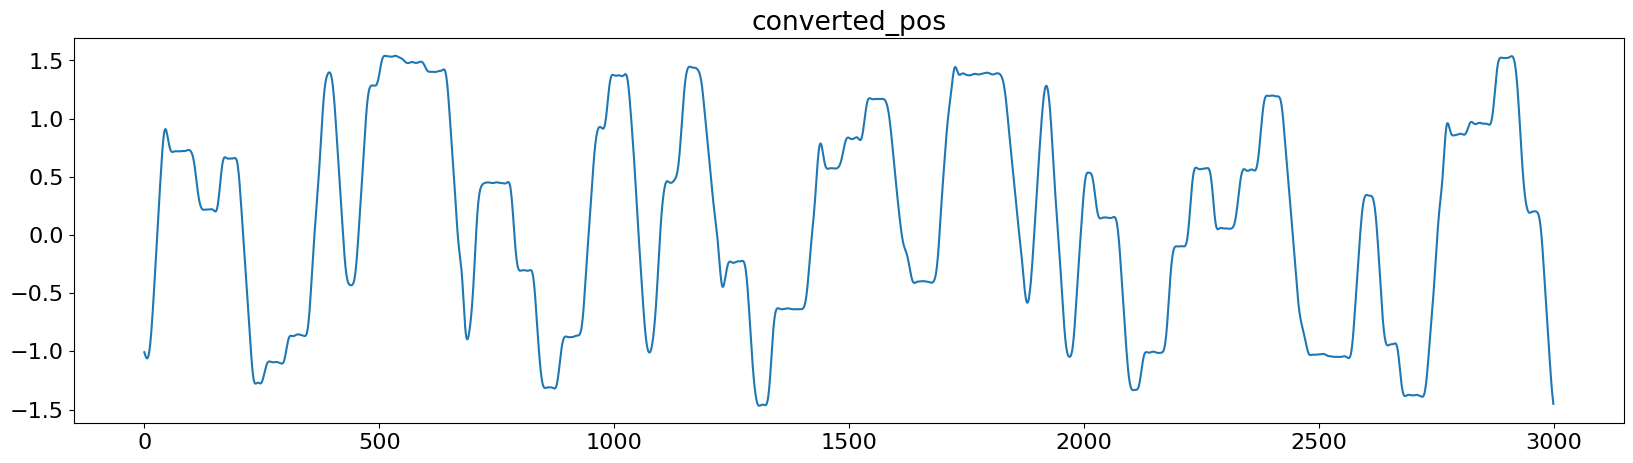

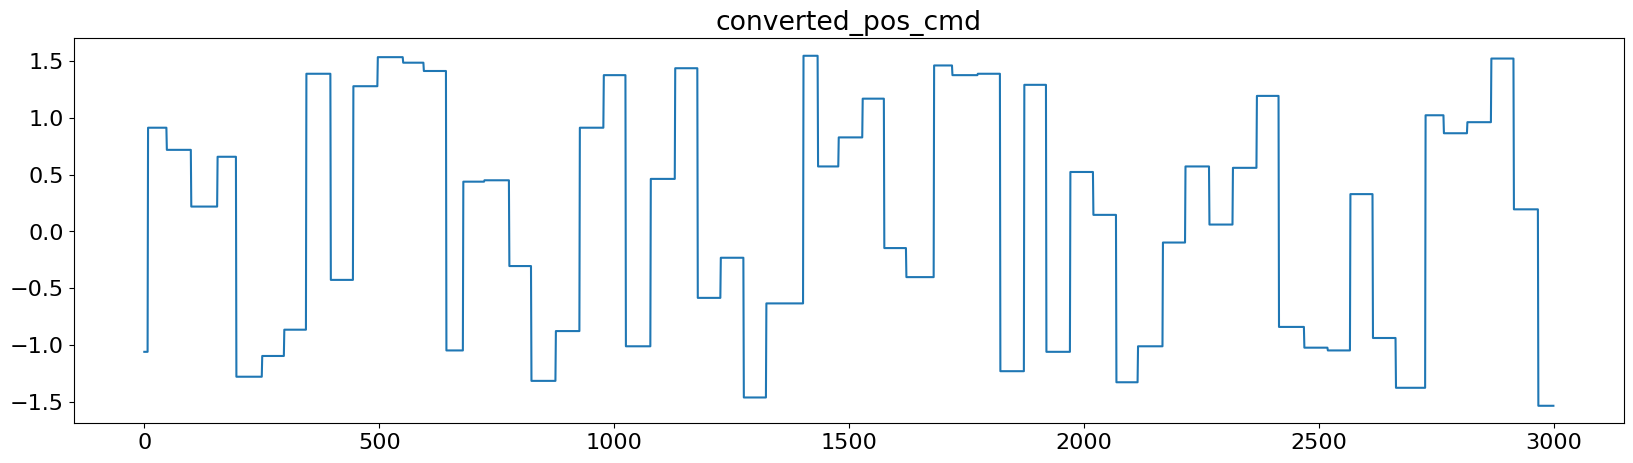

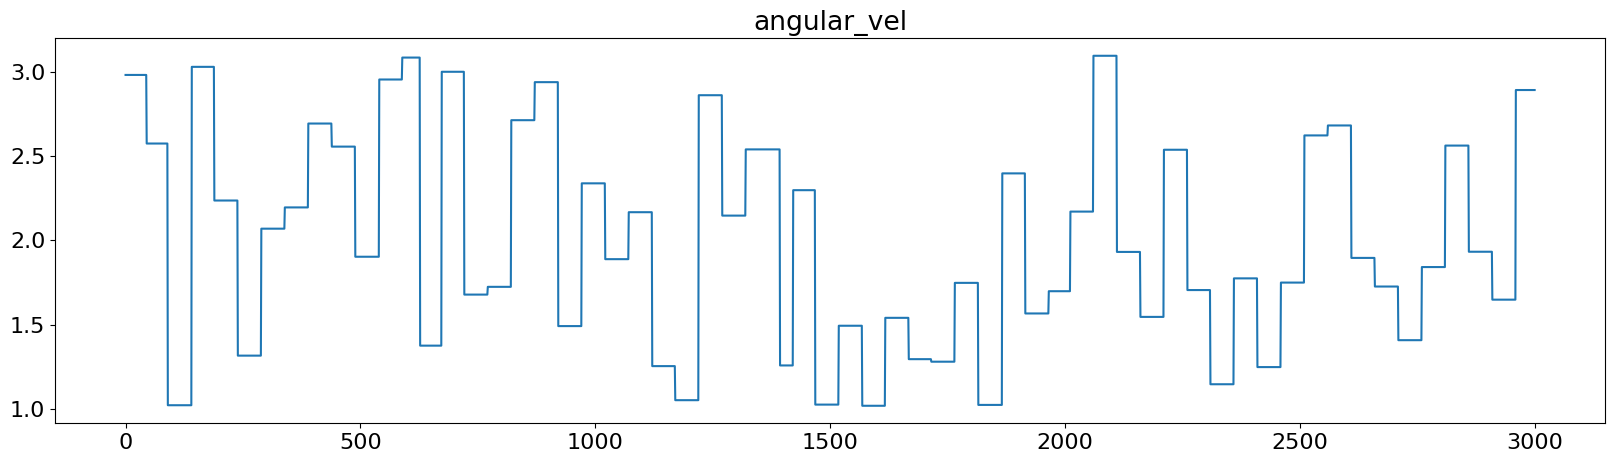

Original dataframe

   timestamp_ft     torque_x     torque_y    torque_z  timestamp_cmd  \
0  1.727952e+09  1234116.405  -572326.869  1261987.88   1.727952e+09   
1  1.727952e+09  1655043.405 -1249361.869   923188.88   1.727952e+09   
2  1.727952e+09  1256844.405  -964057.869   787843.88   1.727952e+09   
3  1.727952e+09  1256844.405  -964057.869   787843.88   1.727952e+09   
4  1.727952e+09   476641.405  -419634.869   764603.88   1.727952e+09   

   frequency  position  position_cmd  converted_pos_cmd  converted_pos  \
0   4.971929       -83         -87.0          -1.059374      -1.010667   
1   4.971929       -83         -87.0          -1.059374      -1.010667   
2   4.971929       -83         -87.0          -1.059374      -1.010667   
3   4.971929       -83         -87.0          -1.059374      -1.010667   
4   4.971929       -88         -87.0          -1.059374      -1.071551   

   torque_x_calibrated  torque_y_calibrated   force_y   force_x  target_angle  \
0             1.28101

In [38]:
df_pos_net = make_dataset_posnet(big_tank_df)

print(df_pos_net.shape)
#plot the force data
for x in range(df_pos_net.shape[1]):
  plt.figure(x)
  plt.title(df_pos_net.columns[x])
  plt.plot(df_pos_net.iloc[:, x][0:3000])
  plt.show()

print(f"Original dataframe\n\n{big_tank_df.head()}\n")
print(f"New dataframe\n\n{df_pos_net.head()}")

## 1D CNN

In [55]:
trainX, trainY = preprocess_data(df_pos_net, 1) # (dataset, num of outputs)

(1989899, 2, 100)
[[[0.1627907  0.1627907  0.1627907  ... 0.72868217 0.72868217 0.72868217]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.1627907  0.1627907  0.1627907  ... 0.72868217 0.72868217 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.1627907  0.1627907  0.1627907  ... 0.72868217 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 ...

 [[0.1627907  0.79069767 0.79069767 ... 0.56976744 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.79069767 0.79069767 0.79069767 ... 0.56976744 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.79069767 0.79069767 0.79069767 ... 0.56976744 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]]


In [56]:
#Crete simple CNN model for time-seris data
def create_cnn_model(trainX, trainY, patience=None):
    model = Sequential()
    model.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))  # Use 'same' padding
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    if patience:
        early_stop = EarlyStopping(monitor='val_loss', patience=patience)
        return model, early_stop
    else:
        return model
    return model

In [57]:
cnn_model, early_stop = create_cnn_model(trainX, trainY, patience=4)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 128)            64128     
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 64)             24640     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 113601 (443.75 KB)
Trainable params: 113

Epoch 1/20
3110/3110 - 15s - loss: 0.0020 - val_loss: 0.0025 - 15s/epoch - 5ms/step
Epoch 2/20
3110/3110 - 14s - loss: 0.0014 - val_loss: 0.0022 - 14s/epoch - 4ms/step
Epoch 3/20
3110/3110 - 14s - loss: 0.0013 - val_loss: 0.0020 - 14s/epoch - 4ms/step
Epoch 4/20
3110/3110 - 14s - loss: 0.0013 - val_loss: 0.0019 - 14s/epoch - 4ms/step
Epoch 5/20
3110/3110 - 14s - loss: 0.0012 - val_loss: 0.0020 - 14s/epoch - 4ms/step
Epoch 6/20
3110/3110 - 13s - loss: 0.0012 - val_loss: 0.0019 - 13s/epoch - 4ms/step
Epoch 7/20
3110/3110 - 13s - loss: 0.0011 - val_loss: 0.0018 - 13s/epoch - 4ms/step
Epoch 8/20
3110/3110 - 14s - loss: 0.0011 - val_loss: 0.0018 - 14s/epoch - 4ms/step
Epoch 9/20
3110/3110 - 14s - loss: 0.0011 - val_loss: 0.0018 - 14s/epoch - 4ms/step
Epoch 10/20
3110/3110 - 14s - loss: 0.0011 - val_loss: 0.0018 - 14s/epoch - 4ms/step
Epoch 11/20
3110/3110 - 14s - loss: 0.0011 - val_loss: 0.0018 - 14s/epoch - 4ms/step
Epoch 12/20
3110/3110 - 14s - loss: 0.0010 - val_loss: 0.0018 - 14s/epoch 

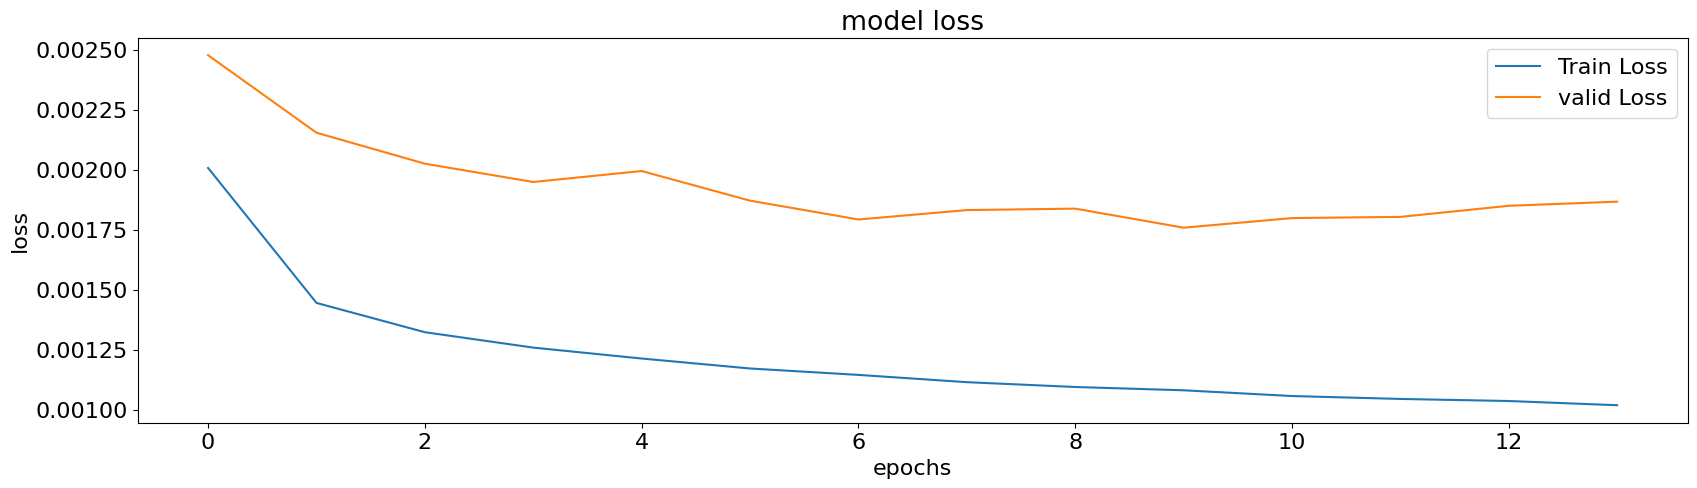

In [58]:
cnn_history = cnn_model.fit(trainX, trainY, epochs=20, batch_size=512, validation_split=0.2, verbose=2, callbacks=[early_stop])

plot_loss(cnn_history)

### Inference

200.0029377937317
199.99191856384277
199.98207998275757
(19899, 2, 100)
[[[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 ...

 [[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]]
(19899, 2, 100)
[[[0.4

(array([[[0.85271318, 0.85271318, 0.85271318, ..., 0.99612403,
          0.99612403, 0.99612403],
         [0.        , 0.        , 0.        , ..., 0.86463732,
          0.86463732, 0.86463732]],
 
        [[0.85271318, 0.85271318, 0.85271318, ..., 0.99612403,
          0.99612403, 0.99612403],
         [0.        , 0.        , 0.        , ..., 0.86463732,
          0.86463732, 0.86463732]],
 
        [[0.85271318, 0.85271318, 0.85271318, ..., 0.99612403,
          0.99612403, 0.99612403],
         [0.        , 0.        , 0.        , ..., 0.86463732,
          0.86463732, 0.86463732]],
 
        ...,
 
        [[0.37209302, 0.37209302, 0.37209302, ..., 0.79844961,
          0.79844961, 0.79844961],
         [0.77518319, 0.77518319, 0.77518319, ..., 0.60433658,
          0.60433658, 0.60433658]],
 
        [[0.37209302, 0.37209302, 0.37209302, ..., 0.79844961,
          0.79844961, 0.79844961],
         [0.77518319, 0.77518319, 0.77518319, ..., 0.60433658,
          0.60433658, 0.6043

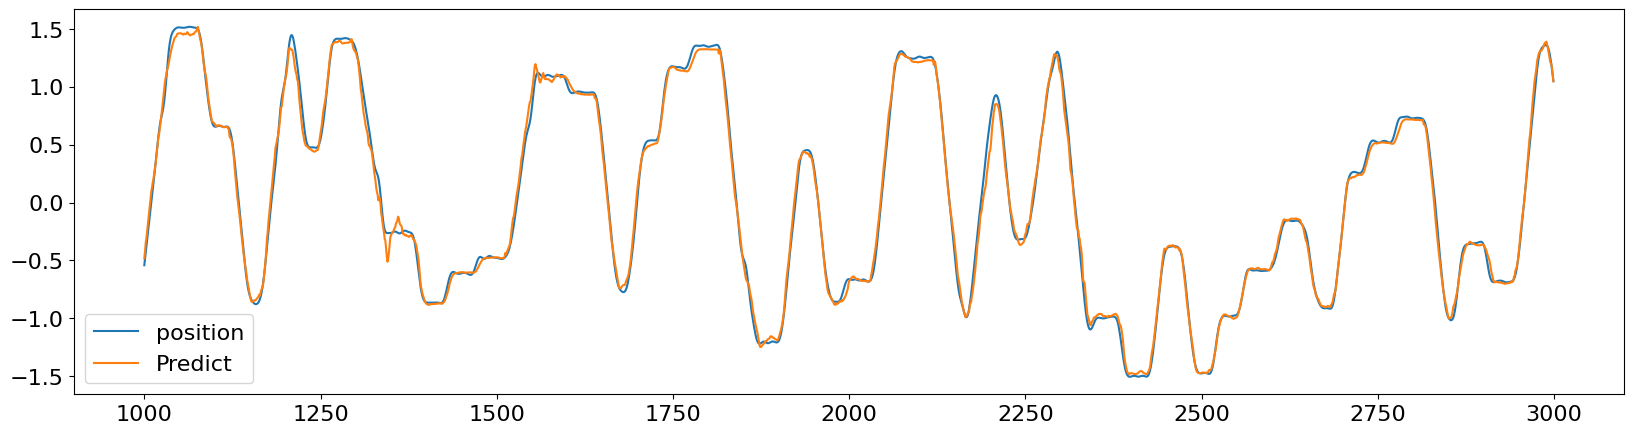

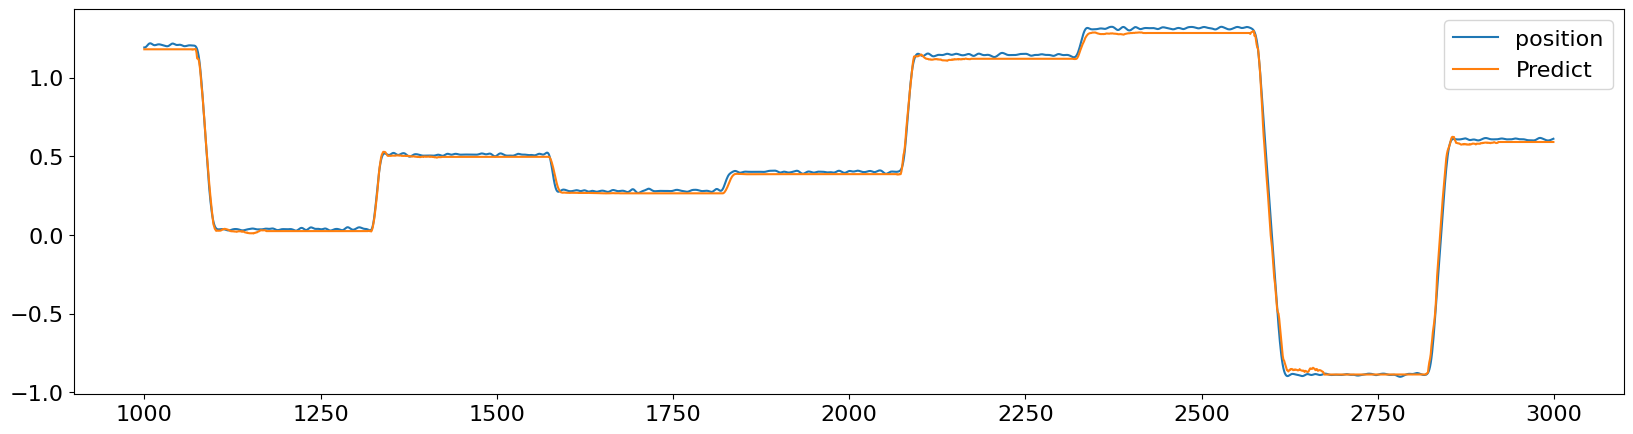

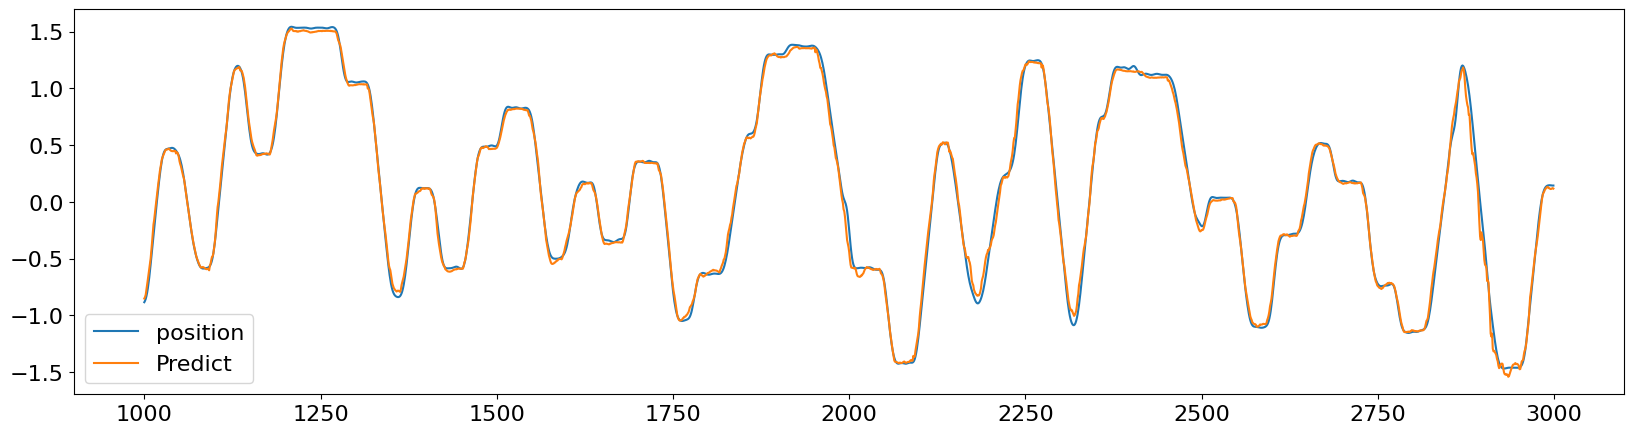

In [59]:
test_posnet_model(cnn_model)

# Estimate forces

## Make dataset

In [44]:
def make_dataset_forcenet(df, is_training_data):
    df_copy = df.copy()
    df_forcenet = pd.DataFrame()
    df_forcenet["force_x_filtered"] = force_filtering(df_copy, "force_x", is_training_data)
    df_forcenet["force_y_filtered"] = force_filtering(df_copy, "force_y", is_training_data)

    converted_pos_cmd = df_copy['converted_pos_cmd']
    angular_vel = df_copy['angular_vel']

    df_forcenet['converted_pos_cmd'] = converted_pos_cmd
    df_forcenet['angular_vel'] = angular_vel
    df_forcenet["converted_pos"] = position_filtering(df_copy, is_training_data)
    df_forcenet.tail()

    return df_forcenet

df_forcenet = make_dataset_forcenet(big_tank_df, is_training_data=True)

16115.063770025969
16115.063770025969
16115.063770025969


(1990000, 5)


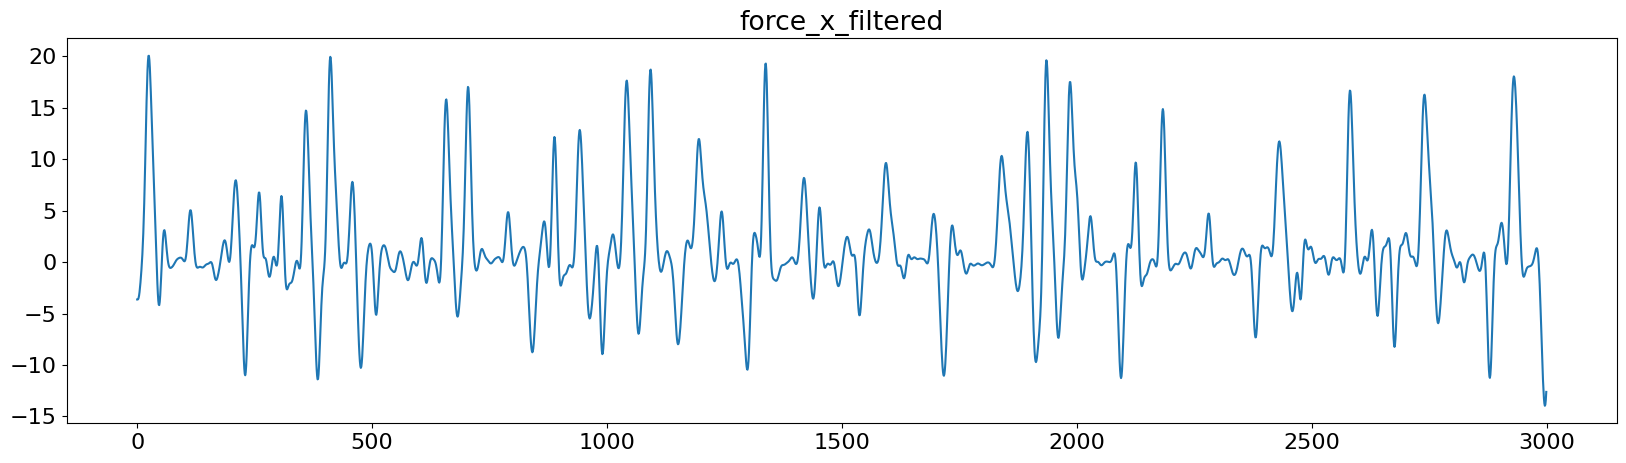

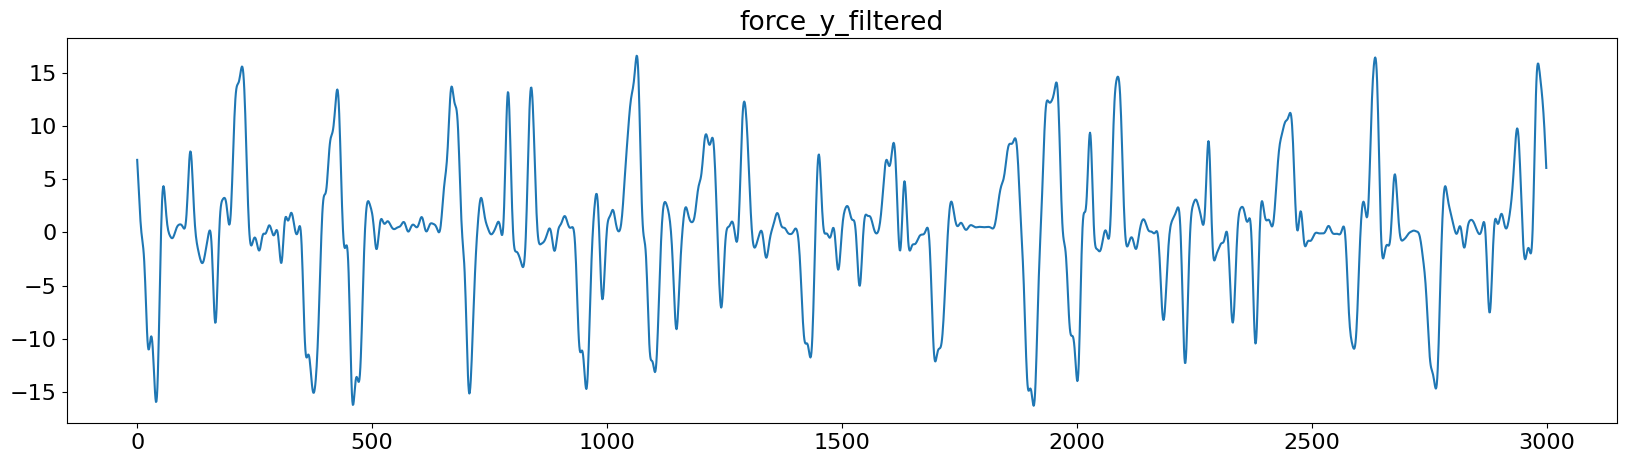

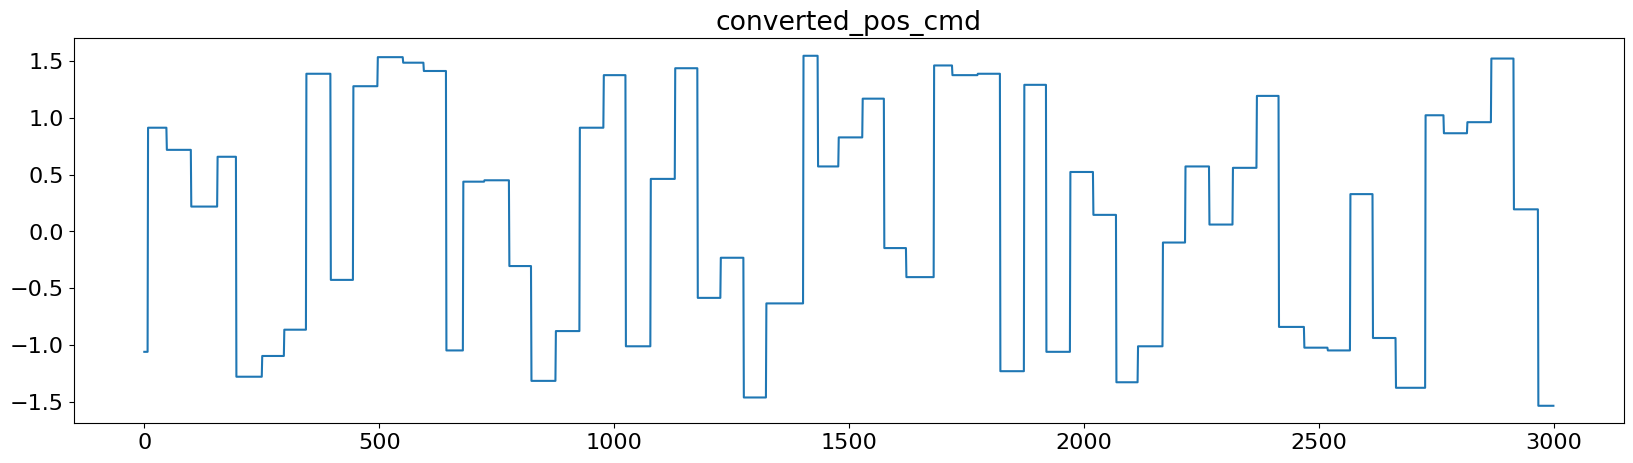

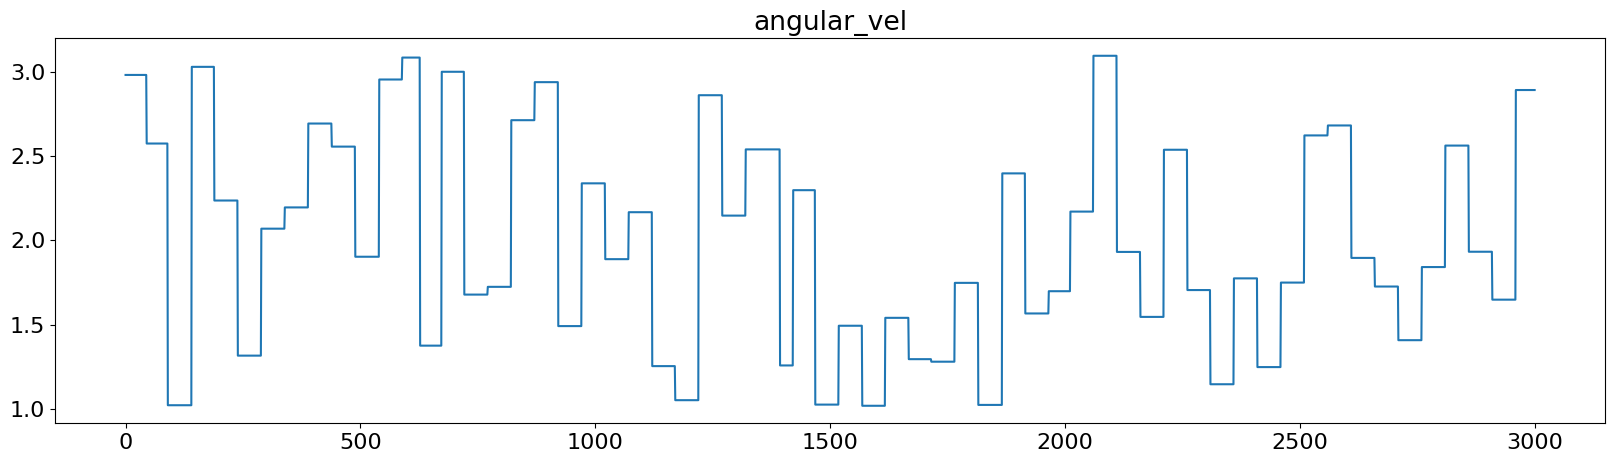

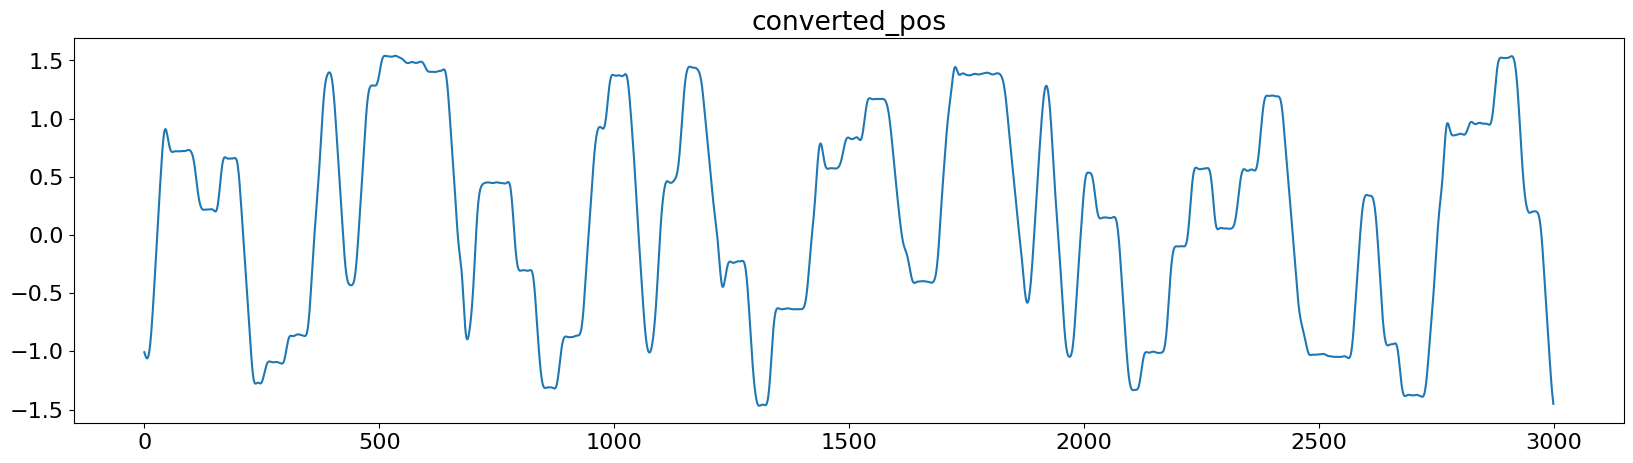

Original dataframe

         timestamp_ft   torque_x    torque_y    torque_z  timestamp_cmd  \
1989995  1.727791e+09  397278.68   58894.911  177338.991   1.727791e+09   
1989996  1.727791e+09  397278.68   58894.911  177338.991   1.727791e+09   
1989997  1.727791e+09  397278.68   58894.911  177338.991   1.727791e+09   
1989998  1.727791e+09  435700.68  142442.911  239877.991   1.727791e+09   
1989999  1.727791e+09  493328.68  242978.911  385971.991   1.727791e+09   

         frequency  position  position_cmd  converted_pos_cmd  converted_pos  \
1989995   3.188104        38         -67.0           -0.81584       0.462715   
1989996   3.188104        38         -67.0           -0.81584       0.462715   
1989997   3.188104        38         -67.0           -0.81584       0.462715   
1989998   3.188104        32         -67.0           -0.81584       0.389655   
1989999   3.188104        32         -67.0           -0.81584       0.389655   

         torque_x_calibrated  torque_y_calibrate

In [45]:
print(df_forcenet.shape)
#plot the force data
# df['force_y'].plot(kind='line')
for x in range(df_forcenet.shape[1]):
  plt.figure(x)
  plt.title(df_forcenet.columns[x])
  plt.plot(df_forcenet.iloc[:3000, x])
  plt.show()

print(f"Original dataframe\n\n{big_tank_df.tail()}\n")
print(f"New dataframe\n\n{df_forcenet.tail()}")

## LSTM

In [46]:
X_train, y_train = preprocess_data(df_forcenet, 2) # (dataset, num of outputs)

(1989899, 3, 100)
[[[0.22041089 0.21687358 0.21349465 ... 0.69148139 0.6905264  0.68919244]
  [0.1627907  0.1627907  0.1627907  ... 0.72868217 0.72868217 0.72868217]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.21687358 0.21349465 0.21050156 ... 0.6905264  0.68919244 0.68741702]
  [0.1627907  0.1627907  0.1627907  ... 0.72868217 0.72868217 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.21349465 0.21050156 0.20811854 ... 0.68919244 0.68741702 0.68512085]
  [0.1627907  0.1627907  0.1627907  ... 0.72868217 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 ...

 [[0.20677511 0.20890495 0.21258487 ... 0.67412384 0.66877373 0.66249164]
  [0.1627907  0.79069767 0.79069767 ... 0.56976744 0.56976744 0.56976744]
  [0.95006243 0.95006243 0.95006243 ... 0.32499961 0.32499961 0.32499961]]

 [[0.20890495 0.21258487 0.21792159 ... 0.66877373 0.66249164 0.65530362]
  [0.7

In [68]:
def LSTM_force_net(patience=None):
  # create and fit the LSTM network
  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(32))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.compile(optimizer='adam', loss='mse')
  if patience:
    early_stop = EarlyStopping(monitor='val_loss', patience=patience)
    return model, early_stop
  else:
    return model


In [70]:
lstm_force_net, early_stop = LSTM_force_net(patience=4)
lstm_force_net.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 3, 128)            117248    
                                                                 
 lstm_12 (LSTM)              (None, 32)                20608     
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                                 
Total params: 144258 (563.51 KB)
Trainable params: 144

### Training

In [71]:
start_time = time.time()
lstm_force_net_history = lstm_force_net.fit(X_train, y_train, batch_size=512, epochs=30, validation_split=0.2, verbose=2, callbacks=[early_stop])
end_time = time.time()
training_time = end_time - start_time
print(training_time)

Epoch 1/30
3110/3110 - 24s - loss: 0.0047 - val_loss: 0.0014 - 24s/epoch - 8ms/step
Epoch 2/30
3110/3110 - 20s - loss: 0.0012 - val_loss: 0.0011 - 20s/epoch - 7ms/step
Epoch 3/30
3110/3110 - 21s - loss: 9.8862e-04 - val_loss: 8.1937e-04 - 21s/epoch - 7ms/step
Epoch 4/30
3110/3110 - 21s - loss: 9.0797e-04 - val_loss: 8.1534e-04 - 21s/epoch - 7ms/step
Epoch 5/30
3110/3110 - 21s - loss: 8.5736e-04 - val_loss: 7.3652e-04 - 21s/epoch - 7ms/step
Epoch 6/30
3110/3110 - 21s - loss: 8.1812e-04 - val_loss: 7.5515e-04 - 21s/epoch - 7ms/step
Epoch 7/30
3110/3110 - 21s - loss: 7.8467e-04 - val_loss: 6.7493e-04 - 21s/epoch - 7ms/step
Epoch 8/30
3110/3110 - 21s - loss: 7.6572e-04 - val_loss: 7.0395e-04 - 21s/epoch - 7ms/step
Epoch 9/30
3110/3110 - 22s - loss: 7.4666e-04 - val_loss: 7.4986e-04 - 22s/epoch - 7ms/step
Epoch 10/30
3110/3110 - 21s - loss: 7.3324e-04 - val_loss: 6.9715e-04 - 21s/epoch - 7ms/step
Epoch 11/30
3110/3110 - 21s - loss: 7.2152e-04 - val_loss: 7.2099e-04 - 21s/epoch - 7ms/step
23

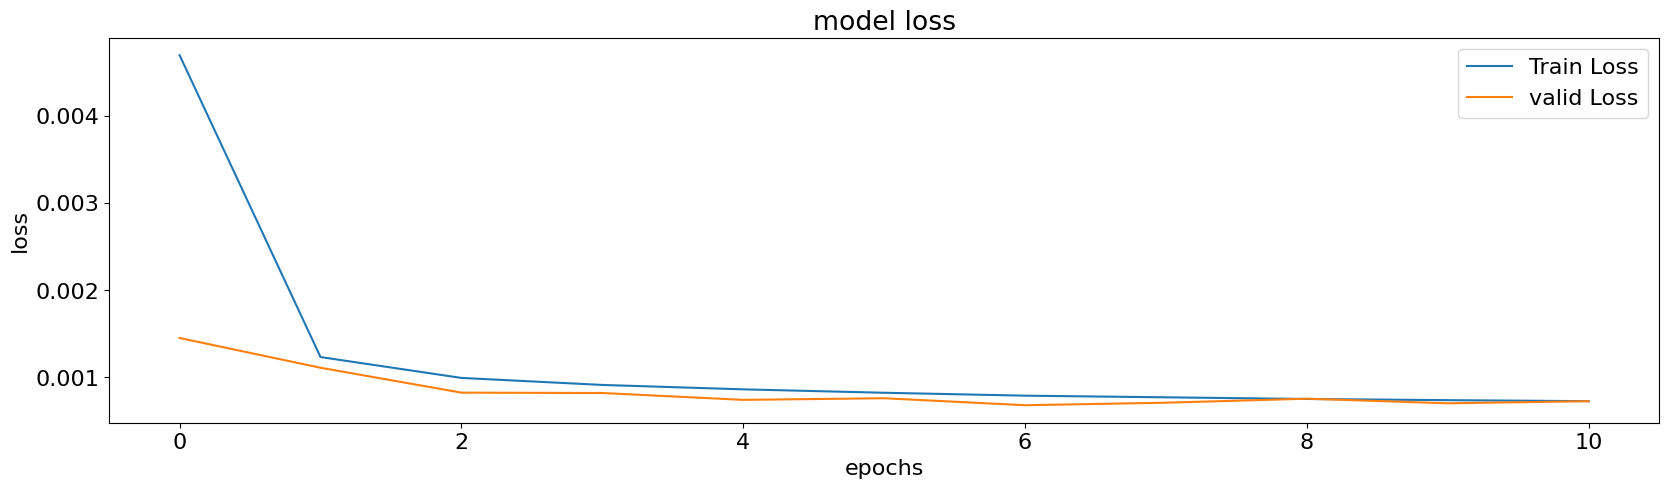

In [72]:
lstm_force_net_loss = plot_loss(lstm_force_net_history)

### Inference

200.0029377937317
200.0029377937317
200.0029377937317
199.99191856384277
199.99191856384277
199.99191856384277
199.98207998275757
199.98207998275757
199.98207998275757
(19899, 3, 100)
[[[0.16972601 0.17130295 0.17397691 ... 0.66795395 0.6841609  0.7010085 ]
  [0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.17130295 0.17397691 0.17858587 ... 0.6841609  0.7010085  0.71814223]
  [0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 [[0.17397691 0.17858587 0.18573495 ... 0.7010085  0.71814223 0.73529057]
  [0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.99612403]
  [0.         0.         0.         ... 0.86463732 0.86463732 0.86463732]]

 ...

 [[0.22396042 0.24131521 0.25994111 ... 0.78543095 0.80149868 0.81712563]
  [0.85271318 0.85271318 0.85271318 ... 0.99612403 0.99612403 0.

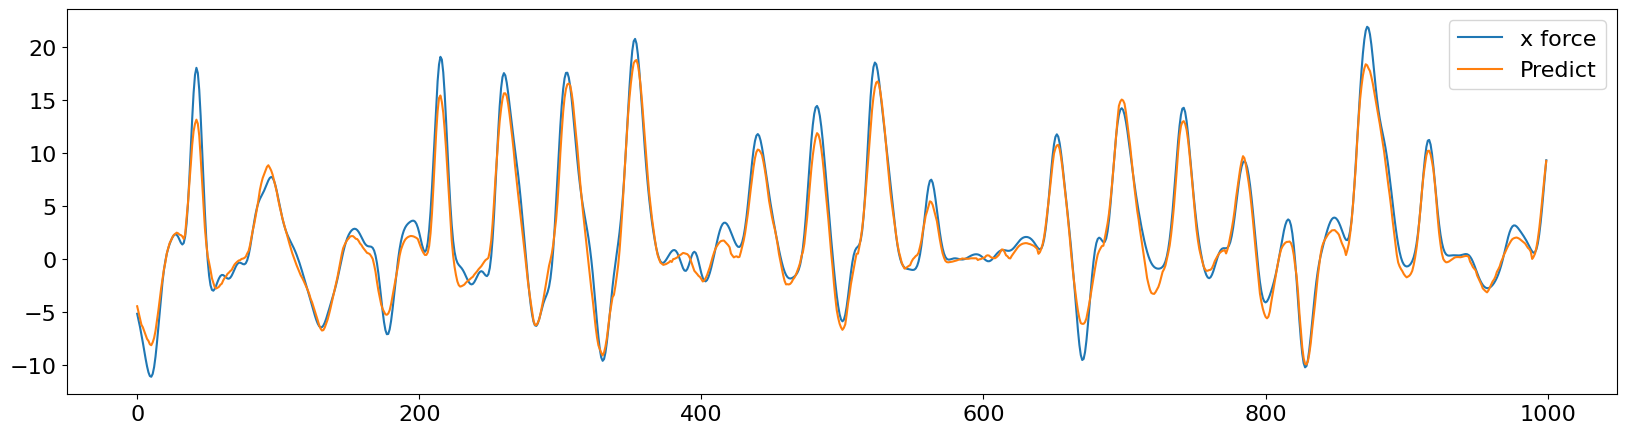

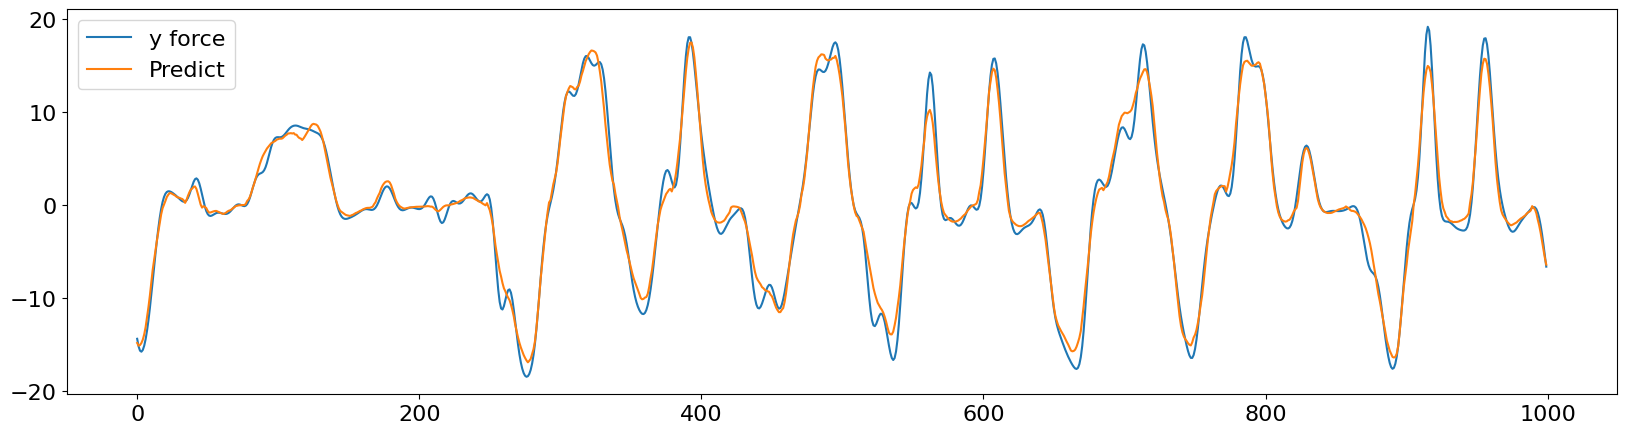

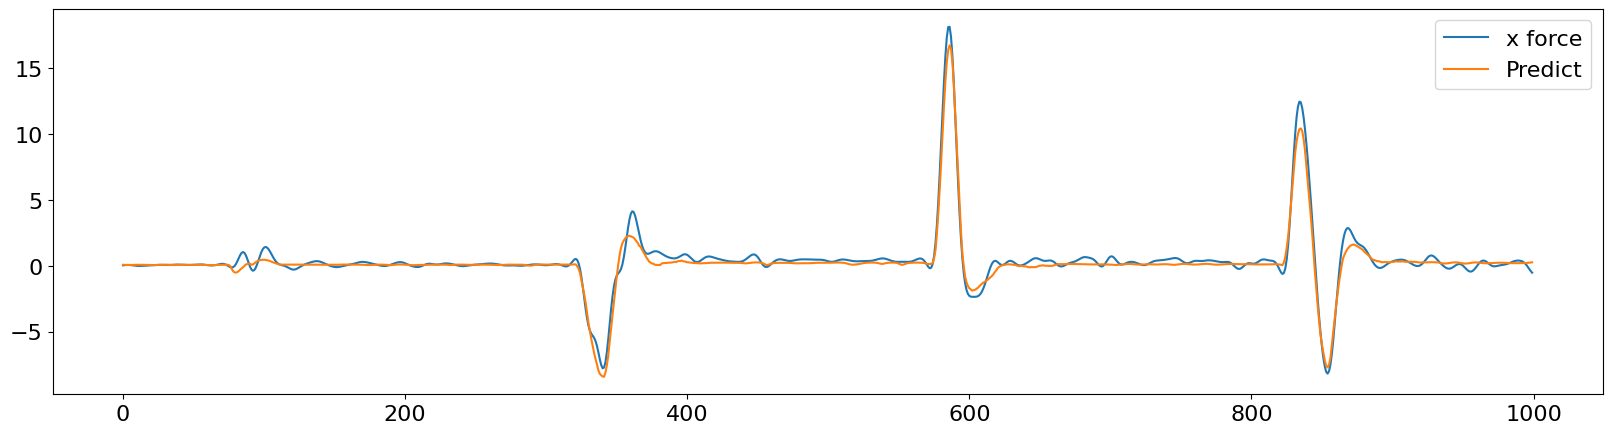

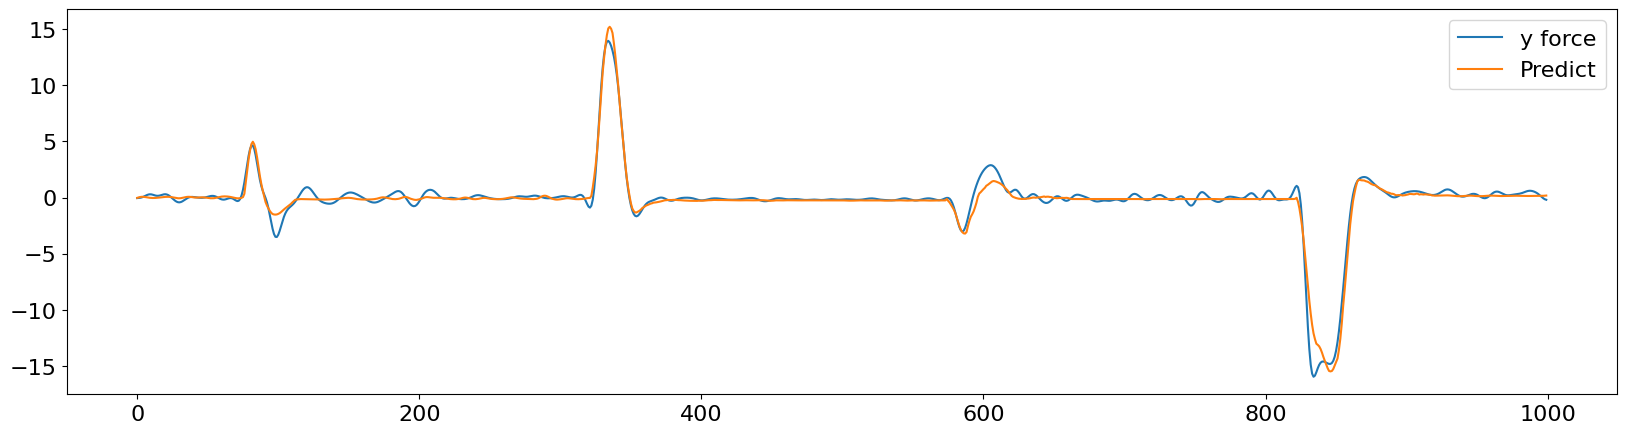

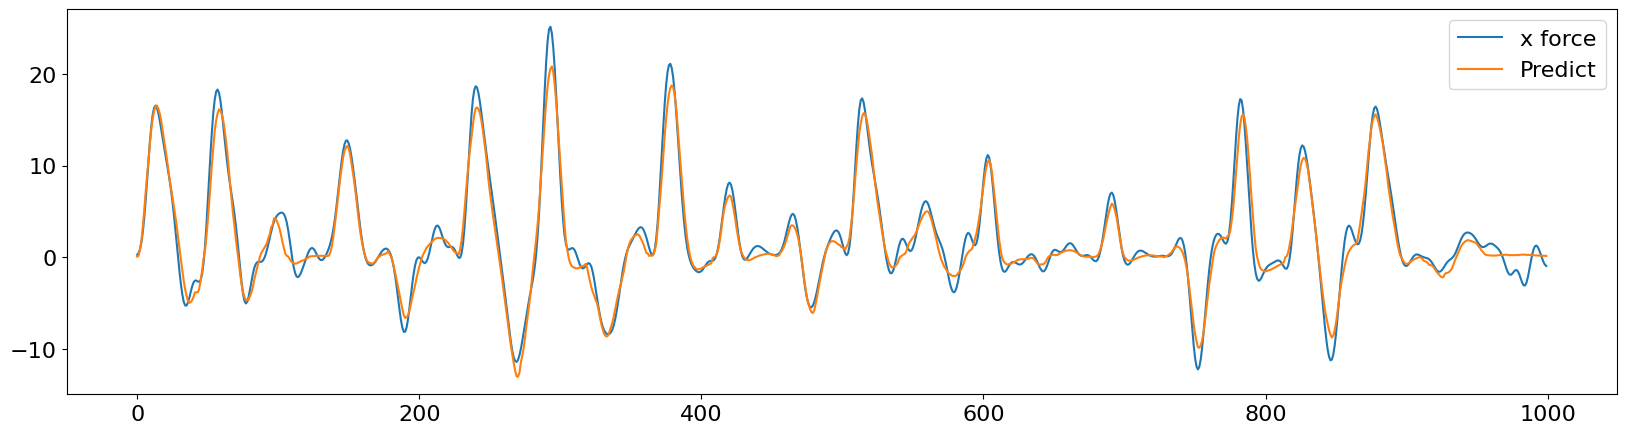

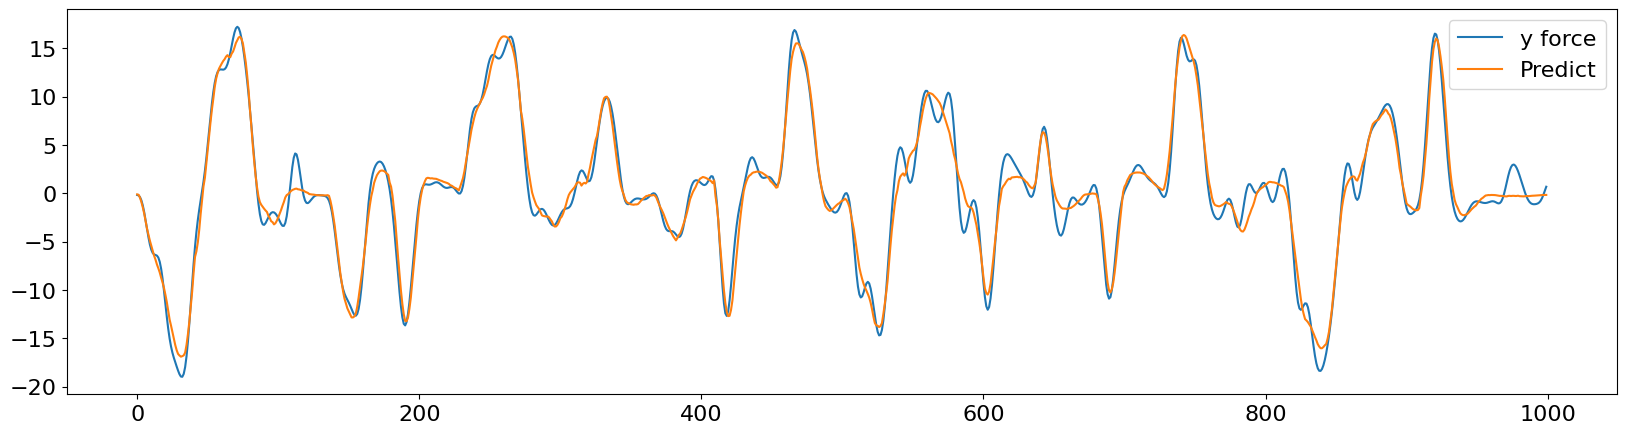

In [73]:
test_forcenet_model(lstm_force_net)